# Examples and tutorial for Variational Bayesian Monte Carlo

In [1]:
import numpy as np
from pyvbmc.vbmc import VBMC

## Example 1: Basic usage
Simple usage of VBMC having as target log likelihood <a href="https://en.wikipedia.org/wiki/Rosenbrock_function">Rosenbrock''s banana function</a>.

In [2]:
# We consider a 2-D problem
D = 2

We set as toy log likelihood for our model a broad Rosenbrock's banana function in 2D (see https://en.wikipedia.org/wiki/Rosenbrock_function).

In [3]:
# log likelihood of your model
def llfun(x):
    x = np.atleast_2d(x)
    return -np.sum(
                (x[0, :-1] ** 2.0 - x[0, 1:]) ** 2.0
                + (x[0, :-1] - 1) ** 2.0 / 100
            )

We define now a prior over the parameters (for simplicity, independent Gaussian prior on each variable, but you could do whatever).

In [4]:
prior_mu = np.zeros((1,D))
prior_var = 3**2*np.ones((1,D))
lpriorfun = lambda x: (-0.5*np.sum((x-prior_mu)**2 / prior_var,axis=1)
                        -0.5*np.log(np.prod(2*np.pi*prior_var)))

So our log joint (that is, unnormalized log posterior density), is:

In [5]:
fun = lambda x: llfun(x) + lpriorfun(x)

We assume an unconstrained domain for the model parameters, and finite plausible bounds which should denote a region of high posterior  probability mass. Not knowing better, we use mean +/- 1 SD of the prior (that is, the top ~68% prior credible interval) to set plausible bounds.

In [6]:
LB = -np.full((1,D), np.inf)                 # Lower bounds
UB = np.full((1,D), np.inf)                  # Upper bounds
PLB = prior_mu - np.sqrt(prior_var)          # Plausible lower bounds
PUB = prior_mu + np.sqrt(prior_var)          # Plausible upper bounds

Analogously, you could set the plausible bounds using the quantiles:

PLB = norminv(0.1587,prior_mu,sqrt(prior_var));

PUB = norminv(0.8413,prior_mu,sqrt(prior_var));

In [7]:
# As a starting point, we use the mean of the prior:
x0 = np.copy(prior_mu)

Alternatively, we could have used a sample from inside the plausible box:

x0 = PLB + rand(1,D).*(PUB - PLB);

We now initialize the VBMC object.  For now, we use default options for the inference.

In [8]:
vbmc = VBMC(fun, x0, LB, UB, PLB, PUB)

Run vbmc.optimize(), which returns the variational posterior VP, the lower bound on the log model evidence ELBO, and its uncertainty ELBO_SD.

In [10]:
vp, elbo, elbo_sd = vbmc.optimize()

/home/marlon/hy/vbmc/pyvbmc/pyvbmc/variational_posterior/variational_posterior.py:139: RuntimeWarning: divide by zero encountered in log
  self.bounds["eta_lb"] = np.log(0.5 * options["tolweight"])


The true log model evidence is lnZ = -2.272.
Note that:
1) The ELBO is a lower bound on the true log model evidence.
2) The reported standard deviation of the ELBO is a measure of the uncertainty on the ELBO as estimated via Bayesian quadrature (the approximation technique used by VBMC). It is NOT a measure of the difference between the ELBO and the true log model evidence,which is generally unknown. 

In [25]:
print("The obtained ELBO is:", elbo)
print("The obtained ELBO_SD is:", elbo_sd)

The obtained ELBO is: -2.3166736125690193
The obtained ELBO_SD is: 0.0007192874399288759


Note that VBMC does not aim for high numerical precision (e.g., beyond the 1st or 2nd decimal place). In most realistic model-fitting problems, a higher resolution is not particularly useful.

We can now examine the obtained variational posterior.

In [19]:
# First, let us generate a million samples from the variational posterior:
Xs, _ = vp.sample(int(3e5))

In [33]:
# Easily compute statistics such as moments, credible intervals, etc.
post_mean = np.mean(Xs,axis=0)             # Posterior mean
post_cov = np.cov(Xs.T)                    # Posterior covariance matrix
print("The approximate posterior mean is:", post_mean)
print("The approximate posterior covariance matrix is\n", post_cov)

The approximate posterior mean is: [0.01621688 0.96853446]
The approximate posterior covariance matrix is
 [[ 1.04419937 -0.00845244]
 [-0.00845244  1.42015293]]


For reporting uncertainty on model parameter estimates, you could use posterior mean +/- SD, or the median and interquartile range (the latter is better for a posterior that deviates substantially from Gaussian).

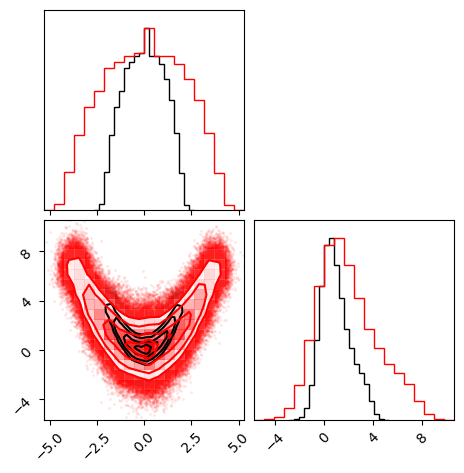

In [26]:
# We visualize the posterior marginals using the CORNERPLOT function:
import matplotlib.pyplot as plt
import corner
plt.rcParams['agg.path.chunksize'] = int(3e5)
figure = corner.corner(Xs)
corner.corner(Xs * 2, fig=figure, color='red')
plt.show()